In [1]:
import pandas as pd

# function to analyze the system statistics of server while running load generation process
def analyze(file_name, num_samples=360):
    cpu_lines = []
    disk_lines = []

    with open(file_name, "r") as f:
        for line in f:
            line = line.strip()
            if line.startswith("avg-cpu:") or not line:
                continue
            parts = line.split()
            if len(parts) == 6:
                cpu_lines.append(float(parts[5]))  # %idle
            if len(cpu_lines) >= num_samples:
                break

    cpu_df = pd.DataFrame(cpu_lines, columns=["%idle"])

    cpu_summary = {
        "cpu_samples": len(cpu_df),
        "cpu_avg_idle": cpu_df["%idle"].mean(),
        "cpu_max_idle": cpu_df["%idle"].max(),
        "cpu_95th_idle": cpu_df["%idle"].quantile(0.95)
    }
  
    with open(file_name, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("avg-cpu:") or line.startswith("Device"):
                continue
            parts = line.split()
            if len(parts) >= 23:  
                disk_lines.append({
                    "Device": parts[0],
                    "r_s": float(parts[1]),
                    "w_s": float(parts[7]),
                    "rkB_s": float(parts[2]),
                    "wkB_s": float(parts[8]),
                    "r_await": float(parts[5]),
                    "w_await": float(parts[11]),
                    "aqu_sz": float(parts[21]),
                    "util": float(parts[22])
                })
            if len(disk_lines) >= num_samples:
                break

    disk_df = pd.DataFrame(disk_lines)

    disk_summary = {
        "disk_samples": len(disk_df),
        "disk_avg_util": disk_df['util'].mean(),
        "disk_max_util": disk_df['util'].max(),
        "disk_95th_util": disk_df['util'].quantile(0.95),
        # "disk_avg_r_s": disk_df['r_s'].mean(),
        # "disk_avg_w_s": disk_df['w_s'].mean(),
        # "disk_avg_r_await": disk_df['r_await'].mean(),
        # "disk_avg_w_await": disk_df['w_await'].mean(),
        # "disk_avg_aqu_sz": disk_df['aqu_sz'].mean()
    }

    summary = {**cpu_summary, **disk_summary, "file": file_name}

    return pd.DataFrame([summary])


In [2]:
files=["system_log_2_.log","system_log_4_.log","system_log_6_.log","system_log_8_.log","system_log_10_.log","system_log_12_.log"]
all_summaries = pd.concat([analyze(f) for f in files], ignore_index=True)

print(all_summaries)

   cpu_samples  cpu_avg_idle  cpu_max_idle  cpu_95th_idle  disk_samples  \
0          360     67.191833         95.71        73.6720           360   
1          360     41.279806         98.12        51.0485           360   
2          359     26.418969         75.61        43.3080           359   
3          360     24.107889         91.44        47.4850           360   
4          360     17.481639         79.39        38.9950           360   
5          359     19.824373         96.35        43.7280           359   

   disk_avg_util  disk_max_util  disk_95th_util                file  
0      43.882750          106.3          84.130   system_log_2_.log  
1      63.151806          108.5          88.115   system_log_4_.log  
2      62.149666          126.2          87.010   system_log_6_.log  
3      70.354778          109.7          90.605   system_log_8_.log  
4      67.823111          133.2          86.105  system_log_10_.log  
5      70.214318           98.3          86.910  syste

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_system_stats(df):
    # Extract number of threads from filename
    df = df.copy()
    df["threads"] = df["file"].str.extract(r"system_log_(\d+)_").astype(int)

    df = df.sort_values("threads")

    plt.figure(figsize=(8, 5))
    plt.plot(df["threads"], df["disk_avg_util"], marker="o", linewidth=2, label="Avg Disk Util%")
    plt.plot(df["threads"], df["disk_95th_util"], marker="s", linewidth=2, label="95th % Disk Util")

    plt.title("Disk Util% vs Number of Load Generator Threads", fontsize=14)
    plt.xlabel("Number of Threads", fontsize=12)
    plt.ylabel("Disk Utilization (%)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df


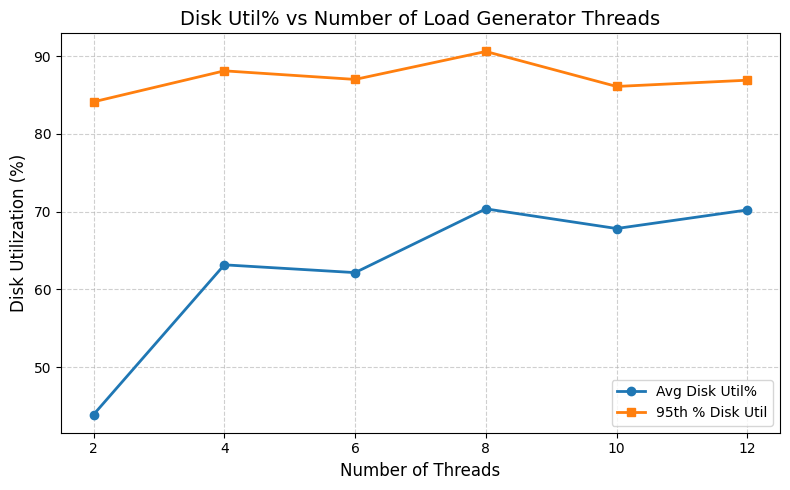

,cpu_samples,cpu_avg_idle,cpu_max_idle,cpu_95th_idle,disk_samples,disk_avg_util,disk_max_util,disk_95th_util,file,threads
0,360,67.191833,95.71,73.6720,360,43.882750,106.3,84.130,system_log_2_.log,2
1,360,41.279806,98.12,51.0485,360,63.151806,108.5,88.115,system_log_4_.log,4
2,359,26.418969,75.61,43.3080,359,62.149666,126.2,87.010,system_log_6_.log,6
3,360,24.107889,91.44,47.4850,360,70.354778,109.7,90.605,system_log_8_.log,8
4,360,17.481639,79.39,38.9950,360,67.823111,133.2,86.105,system_log_10_.log,10
5,359,19.824373,96.35,43.7280,359,70.214318,98.3,86.910,system_log_12_.log,12


In [4]:
plot_system_stats(all_summaries)

In [16]:
import re
import pandas as pd
import matplotlib.pyplot as plt

def parse_experiment_results(filename):
    pattern_threads = re.compile(r"Number of Threads:\s*(\d+)")
    pattern_throughput = re.compile(r"Throughput:\s*([\d.]+)")
    pattern_latency = re.compile(r"Avg latency:\s*([\d.]+)")

    data = {
        "threads": [],
        "throughput": [],
        "avg_latency_ms": []
    }

    with open(filename, 'r') as f:
        for line in f:
            # extract threads
            m = pattern_threads.search(line)
            if m:
                data["threads"].append(int(m.group(1)))
                continue

            # extract throughput
            m = pattern_throughput.search(line)
            if m:
                data["throughput"].append(float(m.group(1)))
                continue

            # extract latency
            m = pattern_latency.search(line)
            if m:
                data["avg_latency_ms"].append(float(m.group(1)))
                continue

    df = pd.DataFrame(data)
    return df


def plot_results(df):
    """
    Plot threads vs throughput and threads vs avg latency.
    """

    # Plot throughput
    plt.figure(figsize=(5,3))
    plt.plot(df["threads"], df["throughput"], marker="o")
    plt.xlabel("Number of Threads")
    plt.ylabel("Throughput (req/sec)")
    plt.title("Threads vs Throughput")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot latency
    plt.figure(figsize=(5,3))
    plt.plot(df["threads"], df["avg_latency_ms"], marker="o")
    plt.xlabel("Number of Threads")
    plt.ylabel("Average Latency (ms)")
    plt.title("Threads vs Avg Latency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


   threads  throughput  avg_latency_ms
0        2       167.0         11.3858
1        4       225.0         17.1858
2        6       245.0         23.8666
3        8       269.0         29.0957
4       10       264.0         37.1511
5       12       269.0         43.9050


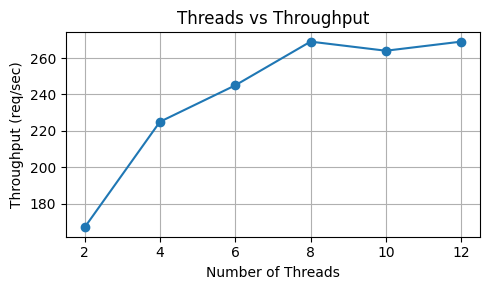

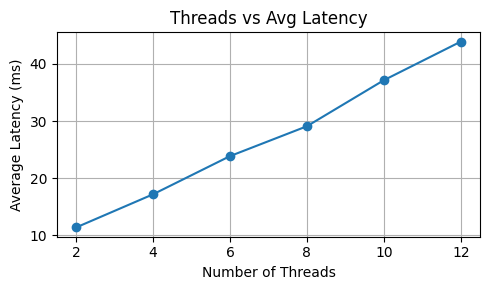

In [17]:
df = parse_experiment_results("./post_stats.txt")
print(df)
plot_results(df)